In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# 1. テスト関数の定義
今回最適化するシステム(関数)を定義する。

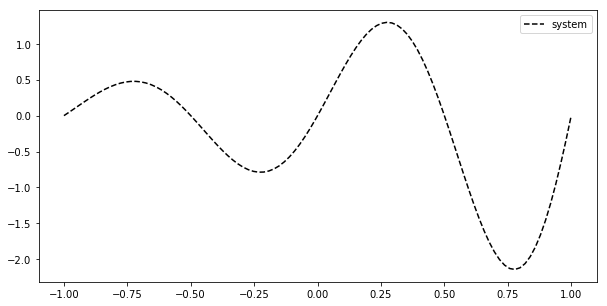

In [2]:
def my_system(x):
    xo=0.2
    return np.exp(x)*np.sin(2*np.pi*x)
#     return x-2*x**2-4*x**4+np.sin(2*np.pi*x)
my_system = np.vectorize(my_system)

def gen_x(etax):
    # recieve normalized coordinates [0-1]
    upper=1
    lower=-1
    x=(etax-0.5)*(upper-lower)
    x=x.reshape(-1,1)
    return x

etax = np.linspace(0,1,100)

xo = gen_x(etax)
yo = my_system(xo)

## Visualize
f, ax = plt.subplots(figsize=(10,5))
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.legend()


# 2. 初期サンプル
初期サンプルを計算する。

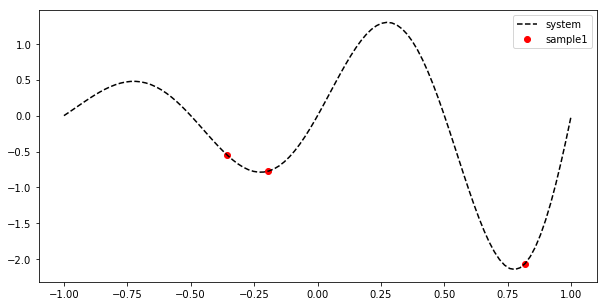

In [3]:
nsample = 3
data_eta = np.random.random_sample(size=nsample).reshape(-1,1)
xs = gen_x(data_eta)
ys = my_system(xs)

## Visualize
f, ax = plt.subplots(figsize=(10,5))
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample1",color="r")
ax.legend()

# 3. サンプル点から関数を予測
ガウス過程を用いてサンプル点から予測分布を計算

In [4]:
#ガウス過程モデルの作成

class GaussProcess:
    
    def __init__(self, theta1=1.0, theta2=1.0 ,theta3=0.1):
        self.theta1 = theta1
        self.theta2 = theta2
        self.theta3 = theta3
        
    def fit(self, x, y):
        #サンプル点(x,y)からカーネル行列(K)を作成
        theta1 = self.theta1
        theta2 = self.theta2
        theta3 = self.theta3
        N = len(x)
        K=np.zeros(N*N).reshape(N,-1)
        for i in range(N):
            for j in range(i, N):
                K[i,j] = theta1*np.exp(-(x[i]-x[j])**2/theta2)+theta3*int(i==j)
                K[j,i] = K[i,j]
        self.K = K
        self.xtrain = x
        self.ytrain = y
        self.Ntrain = N
    
    def predict(self,x):
        #新たなサンプル点(x)に対して予測分布(期待値、分散)を計算する。
        Ntest = len(x)
        Ntrain = self.Ntrain
        xtrain = self.xtrain
        theta1 = self.theta1
        theta2 = self.theta2
        theta3 = self.theta3
        
        ypred = np.zeros(Ntest).reshape(Ntest,1)
        vari = np.zeros(Ntest).reshape(Ntest,1)
        
        for i in range(Ntest):
            k1 = np.zeros(Ntrain).reshape(Ntrain,1)
            for j in range(Ntrain):
                k1[j] =  theta1*np.exp((-(x[i]-xtrain[j])**2)/theta2)        
            k2 = theta1+theta3
        
            Kinv = np.linalg.inv(self.K)
            ypred[i] = k1.T.dot(Kinv).dot(self.ytrain)
            vari[i] = k2 - k1.T.dot(Kinv).dot(k1)
        
        return ypred, vari
        

In [5]:
#サンプルデータをガウス過程にフィッティング
my_gp = GaussProcess(theta1=1.0, theta2=0.05, theta3=0.1)
my_gp.fit(xs,ys)

In [6]:
#新しいサンプル点に対する予測分布の計算

## 新しいサンプル点を均一に作成
etax = np.linspace(0,1,100)
xtest = gen_x(etax)

ypred, vari = my_gp.predict(xtest)

##可視化用にデータ整形
y_upr = ypred+vari
y_upr = y_upr.flatten()
y_lwr = ypred-vari
y_lwr = y_lwr.flatten()

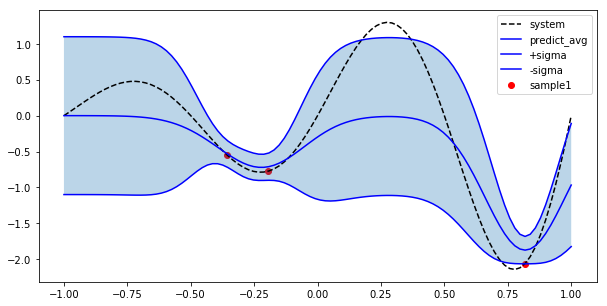

In [7]:
## Visualize
f, ax = plt.subplots(figsize=(10,5))
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample1",color="r")
ax.plot(xtest,ypred,label="predict_avg",color="b")
ax.plot(xtest,ypred+vari,label="+sigma",color="b")
ax.plot(xtest,ypred-vari,label="-sigma",color="b")
ax.fill_between(
    xtest.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

# ４．最適解探索
目的関数を最大化するために、次に試行するべきサンプル点を探す

## 4.1 獲得関数を定義

In [8]:
# 獲得関数を定義
def afunc(xtrain,ytrain,y,vari):
    #下記論文のEI値を参考
    # https://arxiv.org/pdf/1807.02811.pdf
    maxid = np.argmax(ytrain)
    xtrainmax = xtrain[maxid]
    ytrainmax = ytrain[maxid]
    
    delta = y-ytrainmax
    deltap = np.max(delta,0)
    sigma = np.sqrt(vari)
    return deltap+sigma*norm.pdf(delta/sigma)-np.abs(delta)*norm.cdf(delta/sigma)

#獲得関数を計算
ei = np.array([afunc(xs,ys,y,v) for y,v in zip(ypred,vari) ])



/Users/kyohei/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



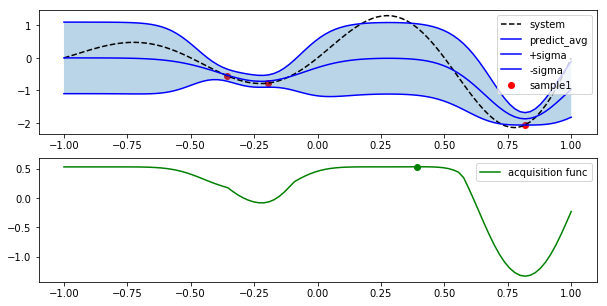

In [9]:
## Visualize
f, axs = plt.subplots(2,1,figsize=(10,5))
ax = axs[0]
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample1",color="r")
ax.plot(xtest,ypred,label="predict_avg",color="b")
ax.plot(xtest,ypred+vari,label="+sigma",color="b")
ax.plot(xtest,ypred-vari,label="-sigma",color="b")
ax.fill_between(
    xtest.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

ax  = axs[1]
ax.plot(xtest,ei,label="acquisition func",linestyle="solid",color="g")
ax.scatter(xtest[np.argmax(ei)],ei.max(),color="g")
ax.legend()

f.show()

## 4.2 次の試行その１

/Users/kyohei/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



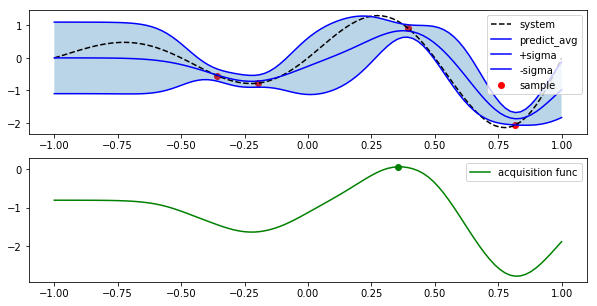

In [10]:
# 獲得関数が最大となるサンプル点を抽出
maxid = np.argmax(ei)
xsnext = xtest[maxid]

## 既存のサンプル点に統合
xs = np.append(xs,xsnext)
ys = my_system(xs)

my_gp = GaussProcess(theta1=1.0, theta2=0.05, theta3=0.1)
my_gp.fit(xs,ys)

ypred, vari = my_gp.predict(xtest)

##可視化用にデータ整形
y_upr = ypred+vari
y_upr = y_upr.flatten()
y_lwr = ypred-vari
y_lwr = y_lwr.flatten()


#獲得関数を計算
ei = np.array([afunc(xs,ys,y,v) for y,v in zip(ypred,vari) ])


## Visualize
f, axs = plt.subplots(2,1,figsize=(10,5))
ax = axs[0]
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample",color="r")
ax.plot(xtest,ypred,label="predict_avg",color="b")
ax.plot(xtest,ypred+vari,label="+sigma",color="b")
ax.plot(xtest,ypred-vari,label="-sigma",color="b")
ax.fill_between(
    xtest.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

ax  = axs[1]
ax.plot(xtest,ei,label="acquisition func",linestyle="solid",color="g")
ax.scatter(xtest[np.argmax(ei)],ei.max(),color="g")
ax.legend()

f.show()

## 4.3 次の試行その２(繰り返し)

/Users/kyohei/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning:

matplotlib is currently using a non-GUI backend, so cannot show the figure



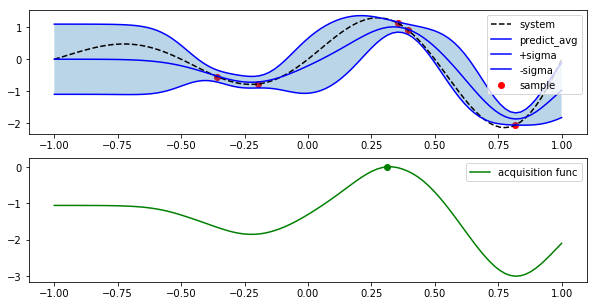

In [11]:
# 獲得関数が最大となるサンプル点を抽出
maxid = np.argmax(ei)
xsnext = xtest[maxid]

## 既存のサンプル点に統合
xs = np.append(xs,xsnext)
ys = my_system(xs)

my_gp = GaussProcess(theta1=1.0, theta2=0.05, theta3=0.1)
my_gp.fit(xs,ys)

ypred, vari = my_gp.predict(xtest)

##可視化用にデータ整形
y_upr = ypred+vari
y_upr = y_upr.flatten()
y_lwr = ypred-vari
y_lwr = y_lwr.flatten()


#獲得関数を計算
ei = np.array([afunc(xs,ys,y,v) for y,v in zip(ypred,vari) ])


## Visualize
f, axs = plt.subplots(2,1,figsize=(10,5))
ax = axs[0]
ax.plot(xo,yo,label="system",linestyle="dashed",color="k")
ax.scatter(xs,ys,label="sample",color="r")
ax.plot(xtest,ypred,label="predict_avg",color="b")
ax.plot(xtest,ypred+vari,label="+sigma",color="b")
ax.plot(xtest,ypred-vari,label="-sigma",color="b")
ax.fill_between(
    xtest.flatten(),
    y_upr,
    y_lwr,
    alpha=0.3,
)
ax.legend()

ax  = axs[1]
ax.plot(xtest,ei,label="acquisition func",linestyle="solid",color="g")
ax.scatter(xtest[np.argmax(ei)],ei.max(),color="g")
ax.legend()

f.show()